In [ ]:
#Load of ionosphere data set
import matplotlib.pyplot as  plt
import pandas as pd
import numpy as np
from sklearn.utils.validation import column_or_1d
from sklearn.feature_selection import VarianceThreshold
import sklearn.utils.random as rd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from re import X
#Read num_rows_to_read first rows
num_rows_to_read = 20000
pathInDrive = "/content/drive/MyDrive/MD/Lab2/dades/";
#pathInDrive = "C:/Universitat/MD/Lab2/"
#seed = np.random()
seed = 1234

XtrainTot = pd.read_csv(pathInDrive + "train_values.csv").drop("building_id", axis = 1)
yTot = pd.read_csv(pathInDrive + "train_labels.csv").drop("building_id", axis = 1)
Xtest = pd.read_csv(pathInDrive + "test_values.csv").drop("building_id", axis = 1)

zTot = pd.concat([XtrainTot, yTot],axis=1)

# Sample the train values and labels
sample_rows = rd.sample_without_replacement(n_population = XtrainTot.shape[0], n_samples = num_rows_to_read, random_state = seed)
Xtrain = XtrainTot.loc[sample_rows]
y = yTot.loc[sample_rows]

original_columns = Xtrain.columns

z = pd.concat([Xtrain, y],axis=1)

g = z.groupby('damage_grade')

Comprovem que la distribució després de 

In [ ]:
print("Orignal distribution:")
print(f"    'damage_grade' == 1 -> {round(len(zTot.loc[zTot['damage_grade'] == 1]) * 100 / len(zTot), 2)}%")
print(f"    'damage_grade' == 2 -> {round(len(zTot.loc[zTot['damage_grade'] == 2]) * 100 / len(zTot), 2)}%")
print(f"    'damage_grade' == 3 -> {round(len(zTot.loc[zTot['damage_grade'] == 3]) * 100 / len(zTot), 2)}%")
# zTot =  None
print("After sampling distribution:")
print(f"    'damage_grade' == 1 -> {round(len(z.loc[z['damage_grade'] == 1]) * 100 / len(z), 2)}%")
print(f"    'damage_grade' == 2 -> {round(len(z.loc[z['damage_grade'] == 2]) * 100 / len(z), 2)}%")
print(f"    'damage_grade' == 3 -> {round(len(z.loc[z['damage_grade'] == 3]) * 100 / len(z), 2)}%")

Orignal distribution:
    'damage_grade' == 1 -> 9.64%
    'damage_grade' == 2 -> 56.89%
    'damage_grade' == 3 -> 33.47%
After sampling distribution:
    'damage_grade' == 1 -> 9.63%
    'damage_grade' == 2 -> 57.27%
    'damage_grade' == 3 -> 33.1%


In [ ]:
print(Xtrain.shape)
print(y.shape)
print(y.dtypes)
print(Xtest.shape)
#y_r = column_or_1d(y, warn=True)
y_r2 = np.ravel(y)
print(y_r2)

(20000, 38)
(20000, 1)
damage_grade    int64
dtype: object
(86868, 38)
[2 2 1 ... 2 2 3]


# Feature selection

## By correlation

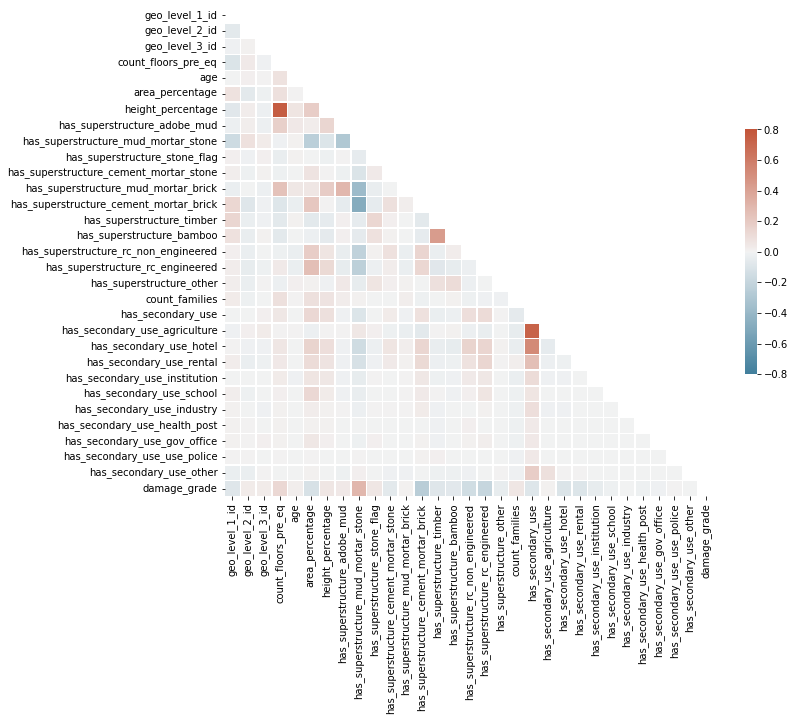

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Compute the correlation matrix
corr = z.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.8, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.rcParams['ytick.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'


In [ ]:
corrThreshold = 0.5
highCorrPair = []

for col in corr.columns:
  for row in corr[abs(corr[col]) > corrThreshold].index:
    if row != col and (len(highCorrPair) == 0 or len(list(filter(lambda el: (el["first"] == row and el["second"] == col), highCorrPair))) == 0): 
      highCorrPair.append({"first": col, "second": row, "value": corr[col][row]})

highCorrPairDF = pd.DataFrame(data = highCorrPair)

from pprint import pprint
print("There's " + str(len(highCorrPair)) + " feature pairs which are highly (>" + str(corrThreshold) + ") correlated, which are: ")
pprint(highCorrPairDF)



There's 3 feature pairs which are highly (>0.5) correlated, which are: 
                 first                         second     value
0  count_floors_pre_eq              height_percentage  0.761464
1    has_secondary_use  has_secondary_use_agriculture  0.730049
2    has_secondary_use        has_secondary_use_hotel  0.530272


## By Information Gain

In [ ]:
from sklearn.feature_selection import mutual_info_classif 
import matplotlib.pyplot as plt
from sklearn import preprocessing

categoricalCols = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']

le = preprocessing.LabelEncoder()
Xenc = Xtrain.copy()
for col in Xenc.columns:
  Xenc[col] = le.fit_transform(Xenc[col])

pd.set_option("display.max_rows", 50, "display.max_columns", None)

In [ ]:
importances = mutual_info_classif(Xenc, np.ravel(y))

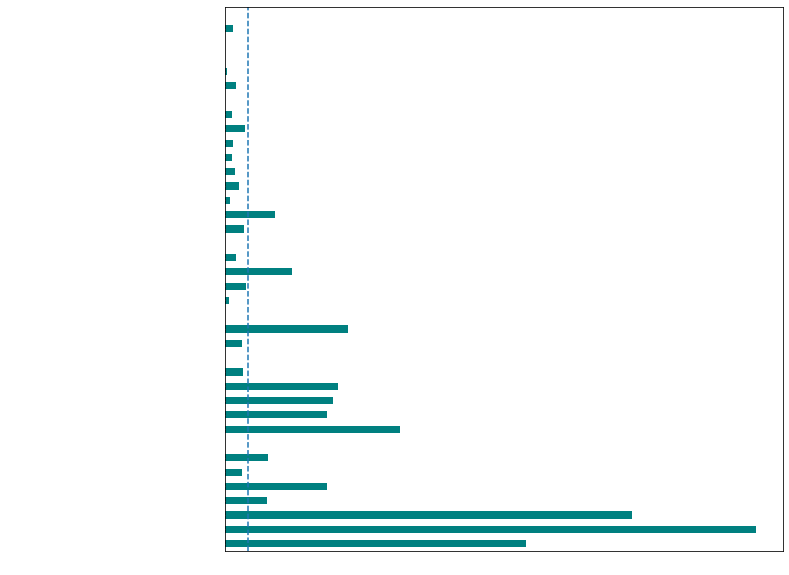

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

igThreshold = 0.01

feat_importances = pd.Series(importances, Xtrain.columns)
feat_importances.plot(kind = 'barh', color = 'teal', figsize=(10, 10))
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['xtick.color'] = 'white'
plt.axvline(x=igThreshold, linestyle='--')

In [ ]:
if not isinstance(feat_importances, pd.DataFrame): feat_importances = feat_importances.to_frame()

In [ ]:
from pprint import pprint

selected_features = []
excluded_features = []

for el in feat_importances.index:
  if (feat_importances[0][el] > igThreshold or 'has_superstructure' in el) and 'has_secondary_use' not in el: selected_features.append(el)
  else: excluded_features.append(el)

In [ ]:
def clean_has_superstructure(lst):
    return [el for el in lst if 'has_superstructure_' not in el]

def clean_has_secondary_use(lst):
    return [el for el in lst if 'has_secondary_use_' not in el]


print("Selected features: ")
pprint(clean_has_superstructure(selected_features) + ['has_superstructure_*'])
print("Excluded features: ")
pprint(clean_has_secondary_use(excluded_features) + ['has_secondary_use_*'])

Selected features: 
['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'height_percentage',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'has_superstructure_*']
Excluded features: 
['area_percentage',
 'land_surface_condition',
 'position',
 'plan_configuration',
 'legal_ownership_status',
 'count_families',
 'has_secondary_use',
 'has_secondary_use_*']


## Features droped

In [ ]:
pprint(len(selected_features))

21


In [ ]:
def containedIn(el, lst):
    return any([el in value for value in lst])

def intersectionContain(lst1, lst2):
    lst3 = [value for value in lst1 if containedIn(value, lst2)]
    return lst3

selected_features.remove('height_percentage')
excluded_features.append('height_percentage')

final_selected_features = intersectionContain(Xtrain.columns, selected_features)
pprint(final_selected_features)

Xtrain = Xtrain[final_selected_features]
Xtest = Xtest[final_selected_features]

['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other']


In [ ]:
pprint(len(final_selected_features))

20


## By Fisher's score

In [ ]:
%%capture
!pip install skfeature-chappers==1.1.0

In [ ]:
print("Xtrain shape: " + str(Xtrain.shape))
print("Xtest shape: " + str(Xtest.shape))
print("y shape: " + str(y.shape))

Xtrain shape: (20000, 20)
Xtest shape: (86868, 20)
y shape: (20000, 1)


In [ ]:
from skfeature.function.similarity_based import fisher_score
%matplotlib inline
ranks = fisher_score.fisher_score(Xenc.to_numpy(), y_r2, mode = "rank")

In [ ]:
fsThreshold = 0.02

ranks = pd.Series(ranks, Xenc.columns)
ordered_ranks = ranks.sort_values(ascending = False)

pprint(ordered_ranks)

In [ ]:
print("Media del rango de todas las columnas:           " + str(np.mean(ordered_ranks)))
print("Media del rango de las columnas seleccionadas:   " + str(np.mean(ordered_ranks[selected_features])))
print("---- Columnas seleccionadas que según el test de Fisher está más del lado de las excluídas: ")
pprint([index for index, el in ordered_ranks[selected_features].items() if el < np.mean(ordered_ranks[excluded_features])])
print("Media del rango de las columnas excluídas:       " + str(np.mean(ordered_ranks[excluded_features])))
print("---- Columnas excluídas que según el test de Fisher está más del lado de las seleccionadas: ")
pprint([index for index, el in ordered_ranks[excluded_features].items() if el > np.mean(ordered_ranks[selected_features])])

NameError: ignored

## One hot

In [ ]:
XtrainE = Xtrain
XtestE = Xtest

for column in XtrainE:
  if XtrainE[column].dtypes == "object":
    col = XtrainE.pop(column)
    XtrainE = pd.concat([XtrainE, pd.get_dummies(col, prefix=column)], axis=1, sort=False)
    col = XtestE.pop(column)
    XtestE = pd.concat([XtestE, pd.get_dummies(col, prefix=column)], axis=1, sort=False)

print("Before Hot Enoding: " + str(len(Xtrain.columns)))
print("After Hot Enoding: " + str(len(XtrainE.columns)))

Before Hot Enoding: 19
After Hot Enoding: 33


In [ ]:
pprint(Xtrain.columns)
pprint(final_selected_features)

Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'roof_type', 'ground_floor_type',
       'other_floor_type', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other'],
      dtype='object')
['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mor

## Variance threshold

In [ ]:
var_selector = VarianceThreshold(threshold=0)
var_selector.fit_transform(XtrainE)
print(list(XtrainE.columns[~var_selector.get_support()]))

[]


## Mean encoding

Primero, cabe destacar que haremos el mean encoding a partir de todas las filas, para evitar tener demasiados valores `NaN` y tener las medias más precisas. 

In [ ]:
import copy
ZtrainTot = pd.concat([XtrainTot, yTot],axis=1)
XtestME = copy.deepcopy(XtestE)

Creamos columnas para agrupar fácilmente.

In [ ]:
target = f"damage_grade"

ZtrainTot['geo_level_1_gb'] = ZtrainTot['geo_level_1_id'].astype(str)
XtestME['geo_level_1_gb'] = XtestME['geo_level_1_id'].astype(str)
ZtrainTot['geo_level_2_gb'] = ZtrainTot['geo_level_1_id'].astype(str) + ',' + ZtrainTot['geo_level_2_id'].astype(str)
XtestME['geo_level_2_gb'] = XtestME['geo_level_1_id'].astype(str) + ',' + XtestME['geo_level_2_id'].astype(str)
ZtrainTot['geo_level_3_gb'] = ZtrainTot['geo_level_1_id'].astype(str) + ',' + ZtrainTot['geo_level_2_id'].astype(str) + ',' + ZtrainTot['geo_level_3_id'].astype(str)
XtestME['geo_level_3_gb'] = XtestME['geo_level_1_id'].astype(str) + ',' + XtestME['geo_level_2_id'].astype(str) + ',' + XtestME['geo_level_3_id'].astype(str)

In [ ]:
for i in range(1,4):
    geo_level_id = f"geo_level_{i}_id"
    geo_level_gb = f"geo_level_{i}_gb"
    loopEl = ZtrainTot.groupby([geo_level_gb])[target].mean()

    ZtrainTot.insert(i+2, geo_level_id + "_enc", ZtrainTot[geo_level_gb].map(loopEl))

    XtestME.insert(i+2, geo_level_id + "_enc", XtestME[geo_level_gb].map(loopEl))
    XtestME.pop(geo_level_gb)

Debido a que el mean encoding está calculanda la media de la variable **damage_grade** en una zona geográfica, si esta no se encuentra en los datos de entrenamiento, no se puede hacer una media. Pondremos la media del nivel justo por encima de la zona geográfica. Solo habría un problema, calcular la media del primer nivel se deberá hacer con la media general. Por suerte no hay.

In [ ]:
for i in range(1,4):
    geo_level_enc = f"geo_level_{i}_id_enc"
    print("    " + geo_level_enc + ": " + str(roulen(XtestME[geo_level_id].loc[np.isnan(XtestME[geo_level_enc])]) * 100 /len(XtestME)) + "%")

    geo_level_1_id_enc: 0.0%
    geo_level_2_id_enc: 0.005755859464935304%
    geo_level_3_id_enc: 0.3764332090067689%


In [ ]:
loopEl = ZtrainTot.groupby(['geo_level_1_id'])[target].mean()
newcolumn = XtestME.loc[np.isnan(XtestME['geo_level_2_id_enc'])].apply( lambda row: loopEl[ZtrainTot.iloc[row.name]['geo_level_1_id']] , axis = 1 )

In [ ]:
XtestME.loc[np.isnan(XtestME['geo_level_2_id_enc']),'geo_level_2_id_enc'] = newcolumn
print(len(XtestME.loc[np.isnan(XtestME['geo_level_2_id_enc'])]))

0


In [ ]:
loopEl = ZtrainTot.groupby(['geo_level_1_id', 'geo_level_2_id'])[target].mean()
newcolumn = XtestME.loc[np.isnan(XtestME['geo_level_3_id_enc'])].apply( lambda row: loopEl[ZtrainTot.iloc[row.name]['geo_level_1_id']][ZtrainTot.iloc[row.name]['geo_level_2_id']] , axis = 1 )

In [ ]:
XtestME.loc[np.isnan(XtestME['geo_level_3_id_enc']),'geo_level_3_id_enc'] = newcolumn
print(len(XtestME.loc[np.isnan(XtestME['geo_level_3_id_enc'])]))

0


In [ ]:
columns_enc = ['geo_level_1_id_enc', 'geo_level_2_id_enc', 'geo_level_3_id_enc']

XtrainME = copy.deepcopy(XtrainE)

XtrainME[columns_enc] = ZtrainTot[columns_enc].loc[XtrainME.index]

In [ ]:
%%capture
XtestME.pop('geo_level_1_id')
XtestME.pop('geo_level_2_id')
XtestME.pop('geo_level_3_id')

XtrainME.pop('geo_level_1_id')
XtrainME.pop('geo_level_2_id')
XtrainME.pop('geo_level_3_id')

In [ ]:
print(XtrainME.shape)
print(XtestME.shape)

(20000, 50)
(86868, 51)


## Balancing

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
under_sampler = RandomUnderSampler(random_state=seed)

XtrainEbal, ybal = under_sampler.fit_resample(XtrainE, y)
XtrainMEbal, ybal = under_sampler.fit_resample(XtrainME, y)
print('-------- Before balancing -> ' + str(len(y)) + ' rows in total')
print(f"    'damage_grade' == 1 -> {round(len(y.loc[y['damage_grade'] == 1]) * 100 / len(y), 2)}%")
print(f"    'damage_grade' == 2 -> {round(len(y.loc[y['damage_grade'] == 2]) * 100 / len(y), 2)}%")
print(f"    'damage_grade' == 3 -> {round(len(y.loc[y['damage_grade'] == 3]) * 100 / len(y), 2)}%")

print('-------- After balancing -> ' + str(len(ybal)) + ' rows in total')
print(f"    'damage_grade' == 1 -> {round(len(ybal.loc[ybal['damage_grade'] == 1]) * 100 / len(ybal), 2)}%")
print(f"    'damage_grade' == 2 -> {round(len(ybal.loc[ybal['damage_grade'] == 2]) * 100 / len(ybal), 2)}%")
print(f"    'damage_grade' == 3 -> {round(len(ybal.loc[ybal['damage_grade'] == 3]) * 100 / len(ybal), 2)}%")


-------- Before balancing -> 20000 rows in total
    'damage_grade' == 1 -> 9.63%
    'damage_grade' == 2 -> 57.27%
    'damage_grade' == 3 -> 33.1%
-------- After balancing -> 5778 rows in total
    'damage_grade' == 1 -> 33.33%
    'damage_grade' == 2 -> 33.33%
    'damage_grade' == 3 -> 33.33%


## Saving the data

In [ ]:
v = 4

from pathlib import Path
Path(f"v{v}").mkdir(parents=True, exist_ok=True)

XtrainME.to_csv(f"v{v}/train_values_Prep_ME.csv", index=False)
XtrainE.to_csv(f"v{v}/train_values_Prep.csv", index=False)
XtestME.to_csv(f"v{v}/test_values_Prep_ME.csv", index=False)
XtestE.to_csv(f"v{v}/test_values_Prep.csv", index=False)
XtrainEbal.to_csv(f"v{v}/train_values_Prep_Bal.csv", index=False)
XtrainMEbal.to_csv(f"v{v}/train_values_Prep_ME_Bal.csv", index=False)
y.to_csv(f"v{v}/train_labels_Prep.csv", index=False)
ybal.to_csv(f"v{v}/train_labels_Prep_Bal.csv", index=False)


In [ ]:
print(selected_features)

['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'legal_ownership_status']


In [ ]:
original_final_columns = intersectionContain(original_columns, final_selected_features)
print("Al final del preprocesamiento nos quedan " + str(len(clean_has_superstructure(original_final_columns))) + " columnas de las originales, más todas las de 'has_superstructure' multiple-choice." )
print("Las columnas son las siguientes: ")
pprint(original_final_columns)

Al final del preprocesamiento nos quedan 13 columnas de las originales, más todas las de 'has_superstructure' multiple-choice.
Las columnas son las siguientes: 
['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'plan_configuration',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'legal_ownership_status']
